<h1> La Regresión de datos de panel: teoría e implementación </h1>

El modelo de efectos mixtos en paneles de datos es una poderosa herramienta utilizada para analizar datos longitudinales o de panel. Este enfoque combina tanto efectos fijos como efectos aleatorios en un solo marco estadístico. Los efectos fijos permiten controlar variables individuales inobservables que varían constantemente en el tiempo, mientras que los efectos aleatorios capturan la variabilidad no explicada por las variables independientes, permitiendo así modelar la heterogeneidad no observada entre las unidades. El modelo de efectos mixtos es especialmente útil cuando se trabaja con datos en los que las observaciones están correlacionadas dentro de las mismas unidades a lo largo del tiempo, lo que permite analizar mejor las tendencias y los efectos de las variables independientes en un contexto longitudinal.

<h1>Contexto</h1>

Las estrategias de inversión macro cuantitativa se centran en el análisis de datos macroeconómicos y financieros a gran escala para tomar decisiones de inversión. Estas estrategias utilizan modelos matemáticos y algoritmos para identificar patrones y oportunidades en los mercados financieros. Su enfoque se basa en factores macroeconómicos, como tasas de interés, inflación, políticas gubernamentales y otros indicadores económicos, con el objetivo de pronosticar movimientos en los mercados y tomar decisiones de inversión informadas. Estas estrategias son parte de la inversión cuantitativa y buscan aprovechar las tendencias y desequilibrios en los mercados para obtener rendimientos positivos.

Históricamente, la información cuantamental ha estado en formatos demasiado desordenados para operar. Se han pasado por alto y olvidado los sellos de tiempo de publicación; la historia se ha comprometido con revisiones; los modelos se aplican con conocimiento previo, y los registros de datos sufren de innumerables observaciones faltantes, errores en los valores, distorsiones no documentadas y quiebres estructurales.

En este contexto, la aplicación de modelos de regresión de panel a conjuntos de datos macro-cuantitativos implica el uso de técnicas estadísticas que permiten analizar y entender las relaciones entre múltiples variables macroeconómicas a lo largo del tiempo. 


<h1>Los datos</h1>

Vamos a aplicar varios modelo de regresión de panel a conjuntos de datos macro-cuantitativos, en particular, utilizamos una variedad de técnicas de regresión, como la regresión de efectos fijos, la regresión de efectos aleatorios y los modelos lineales de efectos mixtos. El conjunto de datos de ejemplo contiene una pequeña selección de indicadores cuantitativos y fundamentales.

<h2>Código en Python</h2>

Para trabajar en Python debemos importar las librerias que vamos a utilizar para cargar los datos y poder analizarlos.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import os

from linearmodels import PooledOLS, PanelOLS
from linearmodels.panel import RandomEffects, compare
from linearmodels.system import SUR
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsap
import statsmodels.formula.api as smf



Luego cargamos el conjunto de datos y vemos las primeras filas y columnas del conjunto de datos. Los datos esta disponible en <a href='https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends'>Kaggle</a> o se puedes descargar directamente desde el repositorio en <a href='https://raw.githubusercontent.com/victormlgh/ModelajePredictivoOptimizacion/master/Semana5/JPMaQS_Quantamental_Indicators.csv'>Github</a>, como hacemos en el codigo.

In [2]:
df = pd.read_csv('JPMaQS_Quantamental_Indicators.csv')
print(df.shape)
df.head()

(3350271, 8)


,Unnamed: 0,real_date,cid,xcat,value,grading,eop_lag,mop_lag
0,0,2000-01-03,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,95.0,292.0
1,1,2000-01-03,AUD,CPIC_SJA_P3M3ML3AR,3.006383,2.0,95.0,186.0
2,2,2000-01-03,AUD,CPIC_SJA_P6M6ML6AR,1.428580,2.0,95.0,277.0
3,3,2000-01-03,AUD,CPIH_SA_P1M1ML12,1.647446,2.0,95.0,292.0
4,4,2000-01-03,AUD,CPIH_SJA_P3M3ML3AR,3.308241,2.0,95.0,186.0


In [3]:
df = df.drop(['Unnamed: 0'],axis=1)
df.columns

Index(['real_date', 'cid', 'xcat', 'value', 'grading', 'eop_lag', 'mop_lag'], dtype='object')

Es importante señalar que, según la descripción, las variables en este conjunto de datos son numéricas y ya están categorizadas. La variable de eop_lag se refiriere a los días transcurridos desde el final del período de observación. La variable de  mop_lag se refiere al número de días transcurridos desde el período medio de observación. La variable de grading denotando un grado de la observación, dando una métrica de la calidad de la información en tiempo real. Finalmente, La variable de value son los últimos valores disponibles para el indicador.

In [4]:
df.describe()


,value,grading,eop_lag,mop_lag
count,3.350271e+06,3.350271e+06,3.350271e+06,3.350271e+06
mean,1.975943e+00,1.368584e+00,1.716700e+01,1.414104e+02
std,4.343438e+00,5.309472e-01,2.815458e+01,2.456948e+02
min,-5.774859e+01,1.000000e+00,-3.000000e+01,-1.500000e+01
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,7.632448e-01,1.000000e+00,0.000000e+00,3.000000e+01
75%,2.852243e+00,2.000000e+00,3.100000e+01,2.250000e+02
max,3.940715e+02,3.000000e+00,3.550000e+02,1.450000e+03


La descripción de cada categoría está disponible en <a href='https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends'>Kaggle</a>.

<h1>Limpieza de datos</h1>

Extraemos un submarco de datos que vamos a utilizar para la mayoría de los modelos. La elección de variables refleja la simple idea de que la inflación debería tener un impacto negativo en los rendimientos de duración del próximo período.

CPIC_SJA_P6M6ML6AR - Última tendencia de precios al consumidor subyacente ajustada

DU02YXR_VT10 - Rendimiento de la posición del receptor fijo, % del capital de riesgo de la posición escalado al objetivo de volatilidad del 10 % (anualizado), asumiendo una rotación mensual: vencimiento de 2 años

In [5]:
df["real_date"] =pd.to_datetime(df["real_date"])

# Prepararamos los filtros

cids = ["EUR", "JPY", "USD"]  # Solo vamos a utlizar el Euro, Yen y Dolar US
for_feats = ["CPIC_SJA_P6M6ML6AR"]  # categorías para el cálculo de características - Última tendencia de precios al consumidor subyacente ajustada
targs = ["DU05YXR_VT10"]  # rentabilidad objetivo
start_date = "2000-01-01"  # earliest sample date - Rendimiento de la posición del receptor fijo

# Create filters

filt1 = df["xcat"].isin(for_feats)  
filt2 = df["real_date"] >= pd.to_datetime(start_date)  
filt3 = df["cid"].isin(cids) 
filt4 = df["xcat"].isin(targs)

# Apply filters

dfx_feats = df[filt1 & filt2 & filt3]  # data frame para variables de características
dfx_target = df[filt4 & filt2 & filt3]  # data frame para variables objetivo


In [6]:
print(dfx_feats.shape)
print(dfx_target.shape)

(17163, 7)
(18522, 7)


Ahora pasamos a reducimos la frecuencia de la serie temporal y retrasamos las características. Este último permite alinear características pasadas con objetivos presentes, es decir, evaluar el poder predictivo de los paneles de características. Los pasos a seguir son:
<ul>
<li>Llevamos una conversión de frecuencia de características y objetivos a medias y sumas trimestrales.</li>
<li>Funciones de retraso (valores pasados asignados a la fecha de hoy)</li>
<li>Pivote funciones y marcos de datos de destino a formatos de panel de series temporales amplias
</li>
<li>Fusionar para unir características/marco de datos de objetivos
</li>
</ul>

In [7]:

dfqx_feats = (dfx_feats.groupby(["cid", "xcat"]).resample("M", on="real_date").mean()["value"]
)
dfqx_feats = dfqx_feats.reset_index()
dfqx_feats = dfqx_feats.dropna()

dfqx_target = (dfx_target.groupby(["cid", "xcat"]).resample("M", on="real_date").sum()["value"])
dfqx_target = dfqx_target.reset_index().dropna()


dfqx_feats["value_lag"] = dfqx_feats.groupby(["cid", "xcat"])["value"].shift(1)
dfqx_feats = dfqx_feats.dropna()

dfqx_feats = dfqx_feats.pivot(index=["cid", "real_date"], columns="xcat", values="value_lag")

dfqx_target = dfqx_target.pivot(index=["cid", "real_date"], columns="xcat", values="value").dropna()

dfx_pan = pd.merge(
    dfqx_target.reset_index(),
    dfqx_feats.reset_index(),
    on=["cid", "real_date"],
    how="outer",
).set_index(["cid", "real_date"])

dfx_pan = dfx_pan[(dfx_pan != 0).all(1)]
dfx_pan = dfx_pan.dropna()

display(dfx_pan.head(5))

xcat            DU05YXR_VT10  CPIC_SJA_P6M6ML6AR
cid real_date                                   
EUR 2000-02-29      0.752012            1.093003
    2000-03-31      2.367384            1.090592
    2000-04-30     -1.375869            1.013280
    2000-05-31     -3.431015            0.975730
    2000-06-30      0.642949            0.968124

<h1>Regresión agrupada</h1>

La forma más sencilla de analizar datos de panel es simplemente agrupar las observaciones de todas las secciones transversales y períodos de tiempo en conjuntos de datos unidimensionales y luego ejecutar una regresión lineal MCO, como se haría con conjuntos de datos unidimensionales. Este método efectivamente ignora las dimensiones del conjunto de datos para formular el modelo subyacente.

Nos basamos en la libreria de linearmodels para realizar un OLS en los datos.

In [8]:
X = sm.add_constant(dfx_pan["CPIC_SJA_P6M6ML6AR"])
lm_pooled = PooledOLS(dfx_pan.DU05YXR_VT10, X).fit(cov_type="clustered")
print(lm_pooled)

                          PooledOLS Estimation Summary                          
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0057
Estimator:                  PooledOLS   R-squared (Between):             -1.7385
No. Observations:                 788   R-squared (Within):               0.0064
Date:                Mon, Oct 16 2023   R-squared (Overall):              0.0057
Time:                        10:04:35   Log-likelihood                   -2073.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.4729
Entities:                           3   P-value                           0.0347
Avg Obs:                       262.67   Distribution:                   F(1,786)
Min Obs:                       222.00                                           
Max Obs:                       283.00   F-statistic (robust):             5.1025
                            

Primero, comprobamos la importancia de las tendencias básicas del IPC, medidas como cambio porcentual en los últimos 6 meses frente a los 6 meses anteriores, estacionalmente y con ajustes bruscos.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


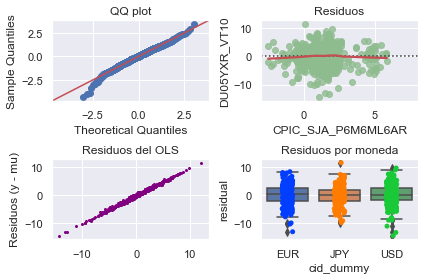

In [9]:
sns.set(rc={"figure.figsize": (15, 8)})
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)


sm.graphics.qqplot(lm_pooled.resids, line="45", fit=True, ax=ax1)
ax1.set_title("QQ plot")
top = ax1.get_ylim()[1] * 0.75


ax2.set_title("Residuos")
ax2.set_xlim((-3,8))
sns.residplot(
    x="CPIC_SJA_P6M6ML6AR",
    y="DU05YXR_VT10",
    data=dfx_pan,
    lowess=True,
    line_kws=dict(color="r"), color = "darkseagreen", ax=ax2
    )

ax3.set_title("Residuos del OLS")
ax3.set_ylabel("Residuos (y - mu)")

ax3.scatter(
    dfx_pan.DU05YXR_VT10,
    lm_pooled.resids,
    s=4, 
    c="purple",
    label="Error de los Residuos",
) 



dfx_pan["cid_dummy"] = dfx_pan.index.get_level_values(0).values

sns.boxplot(x="cid_dummy", y=lm_pooled.resids, data=dfx_pan)
g = sns.stripplot(x="cid_dummy", y=lm_pooled.resids, data=dfx_pan, palette="bright", ax=ax4) 
ax4.set_title("Residuos por moneda")


fig.tight_layout()

plt.show()

Podemos comprobar que una relación se mantiene de forma similar entre las secciones.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


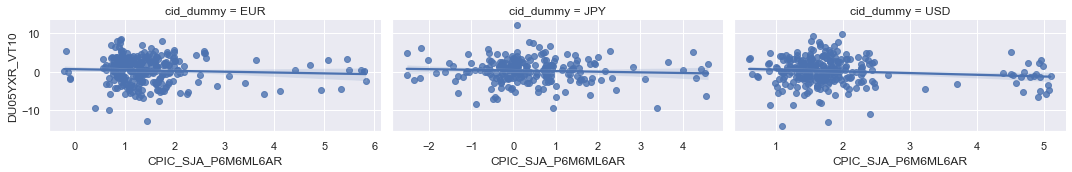

In [10]:
grid = sns.lmplot(
    x="CPIC_SJA_P6M6ML6AR",
    y="DU05YXR_VT10",
    col="cid_dummy",
    sharex=False,
    sharey=True,
    aspect = 2,
    
    col_wrap=3,
    data=dfx_pan,
    height=2.5,
)
fig.tight_layout()

<h1>Regresión de efectos fijos</h1>

Los efectos fijos se pueden estimar con el paquete statsmodels agregando variables ficticias específicas de una sección transversal o de un período al método PooledOLS. La siguiente estimación supone que cada zona monetaria suma o resta una prima fija al rendimiento objetivo.

In [11]:
X = [
    "CPIC_SJA_P6M6ML6AR",
   "cid_dummy",
]
X = sm.add_constant(dfx_pan[X])

sm_fe_cs = PooledOLS(dfx_pan.DU05YXR_VT10, X).fit(cov_type="clustered")

print(sm_fe_cs)

                          PooledOLS Estimation Summary                          
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0072
Estimator:                  PooledOLS   R-squared (Between):              1.0000
No. Observations:                 788   R-squared (Within):               0.0067
Date:                Mon, Oct 16 2023   R-squared (Overall):              0.0072
Time:                        10:04:37   Log-likelihood                   -2072.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.8960
Entities:                           3   P-value                           0.1288
Avg Obs:                       262.67   Distribution:                   F(3,784)
Min Obs:                       222.00                                           
Max Obs:                       283.00   F-statistic (robust):             2.0420
                            

La importancia de los efectos fijos está indicada por los valores de t y los valores p de los coeficientes ficticios. Agregar efectos fijos para la sección transversal solo aumentó el valor absoluto y fortaleció la significancia de la variable independiente elegida, aunque ninguno de los efectos fijos es significativo al nivel del 5%.

Al analizar los efectos fijos entre diferentes períodos, especialmente en series temporales largas, la regresión de panel de efectos fijos puede volverse complicada y difícil de interpretar si se consideran todos los efectos de cada período. Por lo tanto, en este caso, se opta por utilizar años calendario como una variable ficticia adicional, manteniendo también el país como variable ficticia en el análisis.

In [12]:
dfx_pan["year"] = dfx_pan.index.get_level_values(1).year.astype("category")
dfx_pan["date"] = dfx_pan.index.get_level_values(1).astype("category")

X = [
    "CPIC_SJA_P6M6ML6AR",
    "cid_dummy",
"year"
]
X = sm.add_constant(dfx_pan[X])

sm_fe_time = PooledOLS(dfx_pan.DU05YXR_VT10, X).fit(cov_type="clustered")

print(sm_fe_time)

                          PooledOLS Estimation Summary                          
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0883
Estimator:                  PooledOLS   R-squared (Between):              1.0000
No. Observations:                 788   R-squared (Within):               0.0878
Date:                Mon, Oct 16 2023   R-squared (Overall):              0.0883
Time:                        10:04:37   Log-likelihood                   -2039.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.8349
Entities:                           3   P-value                           0.0000
Avg Obs:                       262.67   Distribution:                  F(26,761)
Min Obs:                       222.00                                           
Max Obs:                       283.00   F-statistic (robust):             2.9577
                            

<h1>Regresión de efectos aleatorios</h1>

Una forma de realizar una regresión de panel de efectos aleatorios es usando RandomEffects del paquete linearmodels. 

In [13]:
X = sm.add_constant(dfx_pan["CPIC_SJA_P6M6ML6AR"])
lm_re = RandomEffects(dfx_pan.DU05YXR_VT10, X).fit(cov_type="clustered")
print(lm_re.summary)
print(lm_re.theta.transpose())

                        RandomEffects Estimation Summary                        
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0057
Estimator:              RandomEffects   R-squared (Between):             -1.7385
No. Observations:                 788   R-squared (Within):               0.0064
Date:                Mon, Oct 16 2023   R-squared (Overall):              0.0057
Time:                        10:04:37   Log-likelihood                   -2073.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.4729
Entities:                           3   P-value                           0.0347
Avg Obs:                       262.67   Distribution:                   F(1,786)
Min Obs:                       222.00                                           
Max Obs:                       283.00   F-statistic (robust):             5.1025
                            

Agregar un efecto aleatorio transversal en este ejemplo no cambia mucho los resultados, ya que ninguno de los efectos fijos transversales fue significativo. Podemos usar la función de comparación del módulo para mostrar la salida clave de diferentes modelos de paneles uno al lado del otro.

In [14]:
res = {
    "agrupado": lm_pooled,
    "Efectos fijos unidireccionales": sm_fe_cs,
    "Sección transversal aleatoria específica": lm_re,
    }
print(compare(res))

                                              Model Comparison                                              
                            agrupado Efectos fijos unidireccionales Sección transversal aleatoria específica
------------------------------------------------------------------------------------------------------------
Dep. Variable           DU05YXR_VT10                   DU05YXR_VT10                             DU05YXR_VT10
Estimator                  PooledOLS                      PooledOLS                            RandomEffects
No. Observations                 788                            788                                      788
Cov. Est.                  Clustered                      Clustered                                Clustered
R-squared                     0.0057                         0.0072                                   0.0057
R-Squared (Within)            0.0064                         0.0067                                   0.0064
R-Squared (Between)

<h1>Efectos aleatorios específicos del período de tiempo con</h1>

In [15]:
y = dfx_pan["DU05YXR_VT10"]
X = dfx_pan["CPIC_SJA_P6M6ML6AR"]
X = sm.add_constant(X)

groups = dfx_pan.reset_index().real_date
re = sm.MixedLM(y,X,groups,).fit(reml=True) 
print(re.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  DU05YXR_VT10
No. Observations:  788      Method:              REML        
No. Groups:        283      Scale:               4.3548      
Min. group size:   2        Log-Likelihood:      -1939.4599  
Max. group size:   3        Converged:           Yes         
Mean group size:   2.8                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
const               0.506    0.210  2.409 0.016  0.094  0.917
CPIC_SJA_P6M6ML6AR -0.146    0.086 -1.691 0.091 -0.314  0.023
Group Var           7.053    0.437                           



Para estimar la importancia de los factores aleatorios necesitamos extraer la escala y la varianza de los efectos aleatorios específicos del período del modelo y simplemente dividir la varianza de los efectos aleatorios específicos del período por la suma de dos varianzas.

In [16]:
scale=sm.MixedLM(y,X,groups,).get_scale(re.fe_params, re.cov_re_unscaled, re.vcomp)
RE_explained=((re.cov_re/(re.cov_re+scale))*100).squeeze().round(2)
print ("{}% de Varianza atribuible a factores aleatorios tiempo".format(RE_explained))

random_effects=pd.DataFrame.from_dict(re.random_effects)
random=random_effects.T
print(random.tail(5))

61.83% de Varianza atribuible a factores aleatorios tiempo
            Group Var
2023-04-30   0.428308
2023-05-31  -0.194370
2023-06-30  -0.711978
2023-07-31  -1.648334
2023-08-31  -0.328003


Para ver cómo es la distribución de los residuos del modelo frente a los valores ajustados, podemos utilizar un diagrama de dispersión.

Text(0, 0.5, 'Residuals')

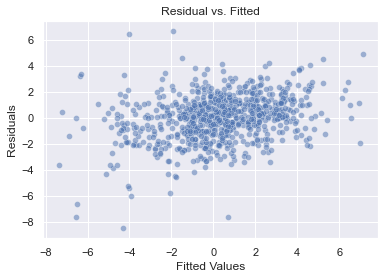

In [17]:
sns.scatterplot(x=(dfx_pan["DU05YXR_VT10"] - re.resid), y=re.resid, 
                   alpha = 0.5).set(title='Residual vs. Fitted')

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

<h1>Modelo lineal de efectos mixtos</h1>

En el primer ejemplo utilizamos las intersecciones del grupo y los coeficientes de pendiente como factores aleatorios. En comparación con el modelo de regresión agrupado anterior, las estimaciones de panel de los coeficientes de intersección y pendiente solo cambian ligeramente, lo que refleja que el poder explicativo de las secciones transversales para los rendimientos de duración mensual es marginal.

In [18]:
groups = dfx_pan.reset_index().cid
lmm1 = smf.mixedlm("DU05YXR_VT10 ~ CPIC_SJA_P6M6ML6AR", dfx_pan, groups=groups,
                       re_formula="1+CPIC_SJA_P6M6ML6AR").fit()
print(lmm1.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      DU05YXR_VT10
No. Observations:      788          Method:                  REML        
No. Groups:            3            Scale:                   11.3263     
Min. group size:       222          Log-Likelihood:          -2076.0238  
Max. group size:       283          Converged:               No          
Mean group size:       262.7                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.558    0.227  2.459 0.014  0.113  1.002
CPIC_SJA_P6M6ML6AR             -0.213    0.150 -1.420 0.156 -0.508  0.081
Group Var                       0.002    0.031                           
Group x CPIC_SJA_P6M6ML6AR Cov -0.001    0.023          

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum 

Ahora podemos derivar intersecciones específicas de secciones transversales y coeficientes de pendiente accediendo al atributo  de random_effects.

In [19]:
print(pd.DataFrame.from_dict(lmm1.random_effects), "\n")
print("Los efectos fijos para el modelo lineal de efectos mixtos con cid como factor aleatorio son \n", lmm1.fe_params)

                         EUR       JPY       USD
Group               0.001998 -0.008272  0.006274
CPIC_SJA_P6M6ML6AR -0.000589  0.004068 -0.003479 

Los efectos fijos para el modelo lineal de efectos mixtos con cid como factor aleatorio son 
 Intercept             0.557695
CPIC_SJA_P6M6ML6AR   -0.213364
dtype: float64


<h2>Próximos pasos</h2>

<ul><li>¿Cómo se comporta con otras monedas?</li>
<li>¿Podemos usar otra variable?</li>
</ul>